# Phase 3: Clustering & Segmentation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
# Load embeddings from Phase 2
embeddings = np.load('customer_embeddings.npy')  # Shape: (n_samples, 10)

In [4]:
embeddings.shape

(2217, 10)

## Determine Optimal Clusters  

This script evaluates the optimal number of clusters for segmenting your customer embeddings (from the autoencoder) using K-Means clustering. It tests cluster counts from 3 to 6 and selects the best one based on two metrics:

    Silhouette Score (higher = better-defined clusters)

    Davies-Bouldin Score (lower = better separation between clusters).

In [7]:
# Evaluate cluster range (3-6)
cluster_range = range(3, 7)
silhouette_scores = []
db_scores = []

for n_clusters in cluster_range:
    # K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)

    # Metrics
    silhouette_scores.append(silhouette_score(embeddings, labels))
    db_scores.append(davies_bouldin_score(embeddings, labels))
# Plot metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal Cluster Count')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, db_scores, 'go-')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Lower is Better')
plt.savefig('cluster_metrics.png', bbox_inches='tight')
plt.close()

# Select best cluster count (max silhouette)
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal clusters: {optimal_clusters} (Silhouette: {max(silhouette_scores):.3f})")

Optimal clusters: 5 (Silhouette: 0.278)


K-Means results are poor (Silhouette <0.3).
Can be overlapping segments (e.g., customers with mixed behaviors).

## Final Clustering  


In [32]:
# K-Means with optimal clusters
final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = final_kmeans.fit_predict(embeddings)

In [33]:
cluster_labels.shape

(2217,)

In [26]:
# Alternative: Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_clusters, random_state=42)
gmm_cluster_labels = gmm.fit_predict(embeddings)

In [27]:
gmm_cluster_labels.shape

(2217,)

In [34]:
# Check if K-mean clusters and GMM are the same
(cluster_labels == gmm_cluster_labels) == False

array([False, False,  True, ..., False, False, False])

In [35]:
# Compare metrics
print("K-Means Silhouette:", silhouette_score(embeddings, cluster_labels))
print("GMM Silhouette:", silhouette_score(embeddings, gmm_cluster_labels))

K-Means Silhouette: 0.27784112
GMM Silhouette: 0.2798353


c:\Users\ADMIN\anaconda3\envs\cs685hw\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ADMIN\anaconda3\envs\cs685hw\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


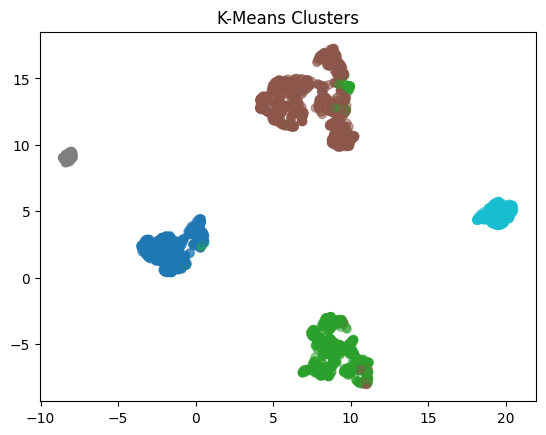

In [36]:
import umap
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.5)
plt.title("K-Means Clusters")
plt.show()

## Cluster Analysis 

In [37]:
# Load original data with features
df = pd.read_csv('preprocessed_campaign_data.csv')
df['Cluster'] = cluster_labels

# Profile clusters
cluster_profiles = df.groupby('Cluster').agg({
    'Income': 'median',
    'Total_Spend': 'median',
    'Recency': 'median',
    'Family_Size': 'median',
    'MntWines': 'sum',
    'NumWebVisitsMonth': 'mean'
}).reset_index()

# Visualize profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profiles.set_index('Cluster'), 
            annot=True, cmap='Blues', fmt='.1f')
plt.title('Customer Segment Profiles', pad=20)
plt.savefig('cluster_profiles.png', bbox_inches='tight')
plt.close()

## Interactive Visualization 

In [38]:
# t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create interactive plot
plot_df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'Cluster': cluster_labels,
    'Income': df['Income'],
    'Total_Spend': df['Total_Spend']
})

fig = px.scatter(plot_df, x='x', y='y', color='Cluster',
                 hover_data=['Income', 'Total_Spend'],
                 title='Customer Segments (t-SNE)')
fig.write_html('interactive_clusters.html')

## Save Results

In [45]:
numeric_cols = [ 'Income', 'Customer_Tenure', 'Total_Spend', 'Family_Size', 'Recency']

In [46]:
df[numeric_cols]

,Income,Customer_Tenure,Total_Spend,Family_Size,Recency
0,0.336654,1.530151,1.704107,-1.275199,0.305137
1,-0.244749,-1.191341,-0.958740,1.390634,-0.386181
2,1.000925,-0.206656,0.295645,-1.275199,-0.800972
3,-1.215793,-1.062688,-0.915196,0.057718,-0.800972
4,0.344295,-0.953829,-0.297215,0.057718,1.549510
...,...,...,...,...,...
2212,0.488734,0.134768,1.241877,0.057718,-0.109654
2213,0.626320,-1.656468,-0.260371,2.723550,0.236005
2214,0.279618,-0.983518,1.074402,-1.275199,1.445812
2215,0.884191,-0.978570,0.407853,0.057718,-1.423158


In [ ]:
# Note:
# After clustering, inverse-transform scaled values to generate proper clsuter descriptions
import joblib
scaler = joblib.load('scaler.joblib')  # Load from disk
numerical_features = ['Income', 'Customer_Tenure', 'Total_Spend', 'Family_Size', 'Recency']
df[numerical_features] = scaler.inverse_transform(df[numerical_features])

In [51]:
df[numerical_features]

,Income,Customer_Tenure,Total_Spend,Family_Size,Recency
0,58138.0,663.0,1617.0,0.0,58.0
1,46344.0,113.0,27.0,2.0,38.0
2,71613.0,312.0,776.0,0.0,26.0
3,26646.0,139.0,53.0,1.0,26.0
4,58293.0,161.0,422.0,1.0,94.0
...,...,...,...,...,...
2212,61223.0,381.0,1341.0,1.0,46.0
2213,64014.0,19.0,444.0,3.0,56.0
2214,56981.0,155.0,1241.0,0.0,91.0
2215,69245.0,156.0,843.0,1.0,8.0


In [52]:
# Save cluster labels
df.to_csv('clustered_customers.csv', index=False)

# Generate cluster descriptions
cluster_descriptions = []
for cluster in range(optimal_clusters):
    subset = df[df['Cluster'] == cluster]
    desc = f"""
    Cluster {cluster} (n={len(subset)}):
    - Median Income: ${subset['Income'].median():,.0f}
    - Median Spend: ${subset['Total_Spend'].median():,.0f}
    - Key Characteristics: {'High' if subset['MntWines'].median() > 300 else 'Low'} wine spenders,
      {'Frequent' if subset['Recency'].median() < 30 else 'Infrequent'} purchasers
    """
    cluster_descriptions.append(desc)

with open('cluster_descriptions.txt', 'w') as f:
    f.write("\n".join(cluster_descriptions))

print("Clustering completed!")
print(f"- Silhouette Score: {silhouette_score(embeddings, cluster_labels):.3f}")
print("- Visualizations saved: cluster_metrics.png, cluster_profiles.png")
print("- Interactive plot: interactive_clusters.html")

Clustering completed!
- Silhouette Score: 0.278
- Visualizations saved: cluster_metrics.png, cluster_profiles.png
- Interactive plot: interactive_clusters.html
